In [1]:
# import sys
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import make_scorer, mean_absolute_error, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from category_encoders import OrdinalEncoder, OneHotEncoder, CountEncoder

import starwrap as sw
from operator import itemgetter



from pathlib import Path
import config

sys.path.append('./starspace36_mono_model')
# import starspace_resources as sw_resources

pd.set_option('display.max_rows', 120)
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (20, 15)

# os.environ['PYDEVD_USE_CYTHON'] = 'Yes'

print(Path.cwd())

/home/sergey/mnt/st1500/Usr/Sergey/TheJob/Otus/ML_advanced2020/home_works/1. Auto_ML/drivendata_flu_shot


In [2]:
X = pd.read_csv("./input/training_set_features.csv", index_col='respondent_id')
y = pd.read_csv("./input/training_set_labels.csv", index_col='respondent_id')
submission_format = pd.read_csv("./input/submission_format.csv", index_col='respondent_id')
test_set = pd.read_csv("./input/test_set_features.csv", index_col='respondent_id')

In [3]:
print('y.head()')
y.head()


y.head()


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [4]:
#  Encoders

ordinal_label_encoder_pipe = Pipeline([

    ('label-encoder', OrdinalEncoder(cols=config.categorical)),
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('scaler', StandardScaler()),
    # ('regressor', BayesianRidge())
])

In [5]:
print("test_set")
test_set.head()


test_set


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [6]:
# split for starspace and catboost datasets
X.replace(to_replace=config.ordinal_to_replace, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

In [7]:
ordinal_encoder = ordinal_label_encoder_pipe.fit(X=X_train)
X_train = pd.DataFrame(data=ordinal_encoder.transform(X_train),
                 index=X_train.index,
                 columns=X_train.columns).astype(int)

X_train
print('есть ли после трансформации OrdinalEncoder значения не int', any(X_train.dtypes != int))

/home/sergey/anaconda3/envs/ML_advanced2020.python3.6/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


есть ли после трансформации OrdinalEncoder значения не int False


In [8]:
X_test = pd.DataFrame(data=ordinal_encoder.transform(X_test),
                 index=X_test.index,
                 columns=X_test.columns).astype(int)

print('X_test')
print('есть ли после трансформации OrdinalEncoder значения не int', any(X_test.dtypes != int))

X_test
есть ли после трансформации OrdinalEncoder значения не int False


In [9]:
test_set.replace(to_replace=config.ordinal_to_replace, inplace=True)
test_set = pd.DataFrame(data=ordinal_encoder.transform(test_set),
                 index=test_set.index,
                 columns=test_set.columns).astype(int)

test_set = test_set.astype(str)


In [10]:
h1n1_train_counts = y_train.h1n1_vaccine.value_counts()
h1n1_test_counts = y_test.h1n1_vaccine.value_counts()

print("соотношения классов")
print(f"h1n1_train_counts train \n {h1n1_train_counts.values} {h1n1_train_counts[1] / h1n1_train_counts[0]}")
print("h1n1_test_counts test \n", h1n1_test_counts.values, h1n1_test_counts[1] / h1n1_test_counts[0])

соотношения классов
h1n1_train_counts train 
 [14713  3981] 0.27057704071229527
h1n1_test_counts test 
 [6320 1693] 0.267879746835443


In [11]:
# По какой-то причине catboost Pool находит нецелые != int значения в датасете !!!!
# перевожу в str

X_train = X_train.astype(dtype=str)
X_test = X_test.astype(dtype=str)
test_set = test_set.astype(dtype=str)

In [12]:
# model training
models = {}
for col in y_train.columns:
    train_set = Pool(data=X_train, label=y_train[col], cat_features=X_train.columns)
    val_set = Pool(data=X_test, label=y_test[col], cat_features=X_test.columns)
    print('ok')
    model = CatBoostClassifier(**config.params)
    model.fit(train_set, eval_set=val_set, use_best_model=True, )
    # model.fit(train_set) # , eval_set=val_set, use_best_model=True, plot=True)
    models[col] = model
print('model training ok')

ok
0:	test: 0.7130551	best: 0.7130551 (0)	total: 110ms	remaining: 45m 57s
100:	test: 0.8286059	best: 0.8286151 (98)	total: 4.05s	remaining: 16m 39s
200:	test: 0.8354214	best: 0.8354274 (196)	total: 8.09s	remaining: 16m 38s
300:	test: 0.8460137	best: 0.8460584 (298)	total: 12.1s	remaining: 16m 32s
400:	test: 0.8515394	best: 0.8515394 (400)	total: 16.1s	remaining: 16m 29s
500:	test: 0.8549965	best: 0.8549969 (499)	total: 20.3s	remaining: 16m 30s
600:	test: 0.8576556	best: 0.8576556 (600)	total: 24.6s	remaining: 16m 37s
700:	test: 0.8594654	best: 0.8594654 (700)	total: 28.8s	remaining: 16m 37s
800:	test: 0.8605680	best: 0.8605753 (798)	total: 33.1s	remaining: 16m 39s
900:	test: 0.8615127	best: 0.8615127 (900)	total: 37.4s	remaining: 16m 40s
1000:	test: 0.8623597	best: 0.8623597 (1000)	total: 41.8s	remaining: 16m 42s
1100:	test: 0.8629903	best: 0.8629903 (1100)	total: 46.1s	remaining: 16m 40s
1200:	test: 0.8633353	best: 0.8633353 (1200)	total: 50.4s	remaining: 16m 39s
1300:	test: 0.8636624

h1n1_vaccine
seasonal_vaccine


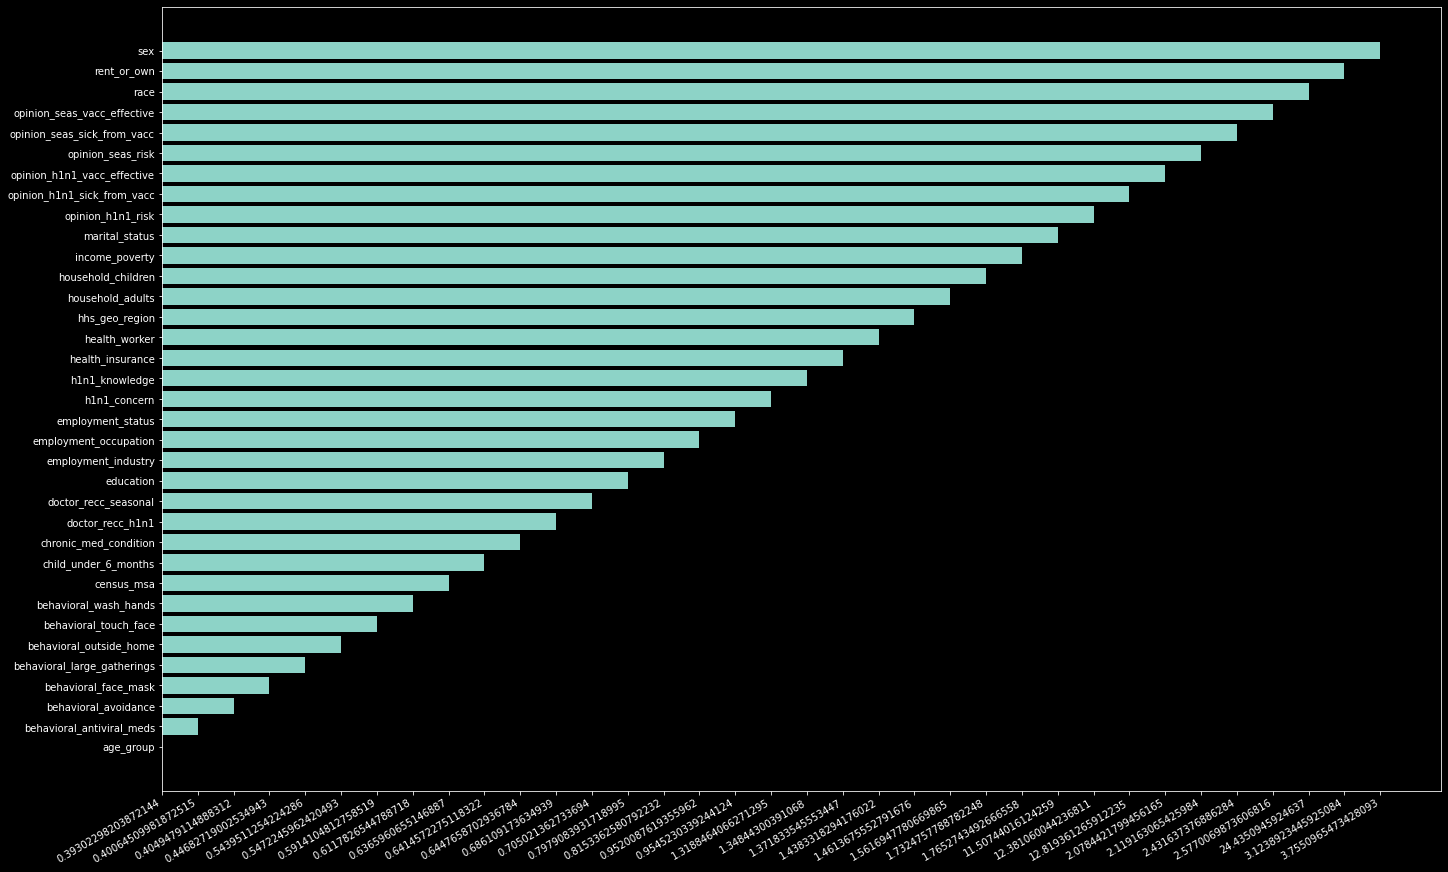

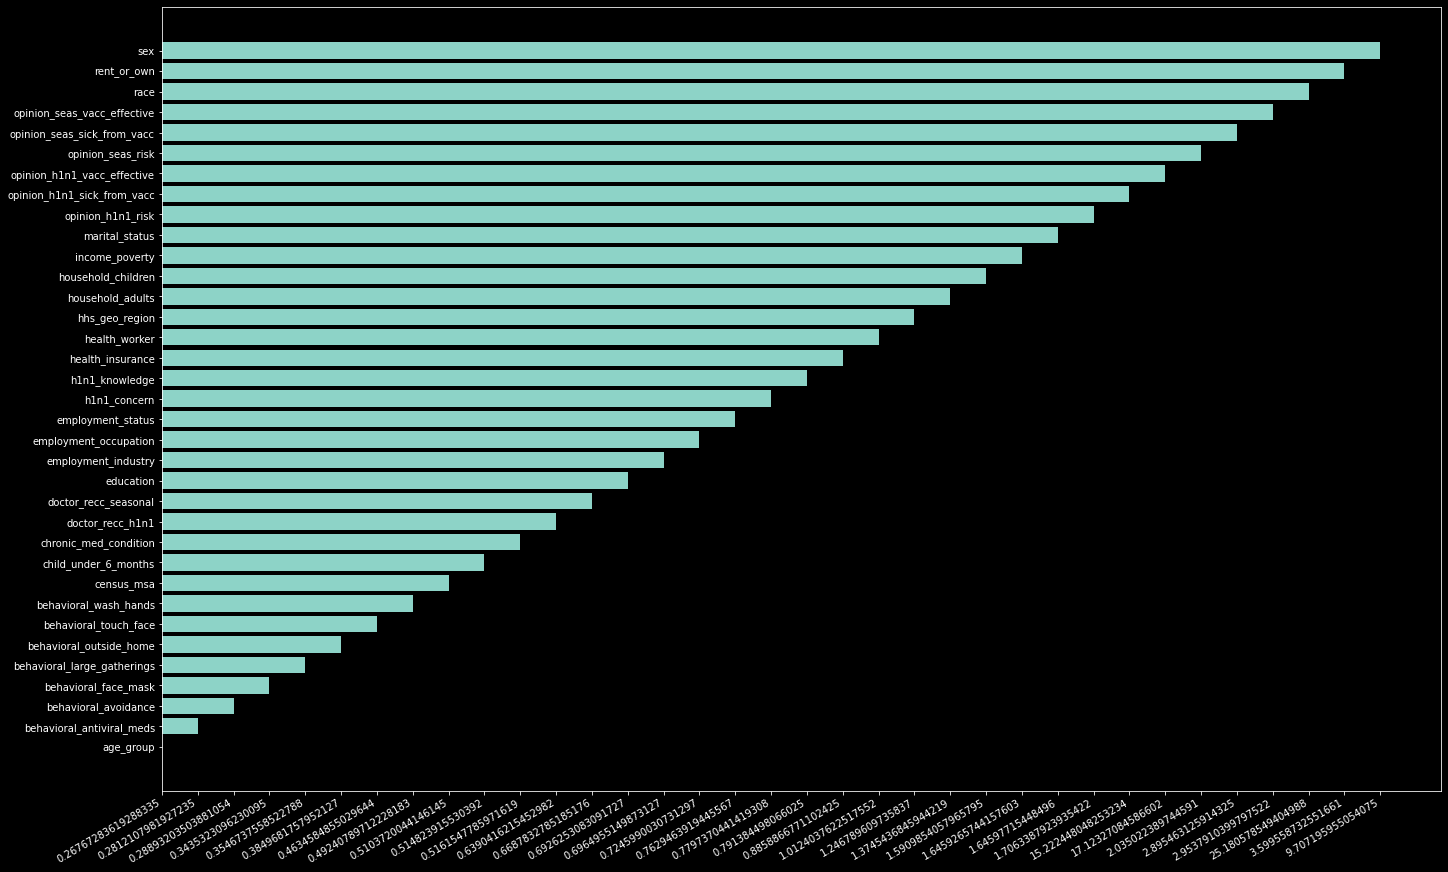

In [13]:
for model_name, model in models.items():
    print(model_name)
    for feature_name, feature_importance in zip(model.feature_names_, model.feature_importances_):
        if feature_importance < 0.01:
            print( feature_name, feature_importance)

    importances_np = np.sort(np.array([model.feature_importances_, model.feature_names_]), axis=1)

    fig, ax = plt.subplots(figsize=(20, 12), constrained_layout=True)
    ax.barh(importances_np[1], importances_np[0], align='center');
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")


In [14]:
print("submission")
submission_df = pd.DataFrame(index=test_set.index)

for col, model in models.items():
    test_pool = Pool(test_set, cat_features=X_test.columns)
    submission_df[col] = model.predict_proba(test_pool)[:, 1]
    print("submission_df.shape", submission_df.shape)
    print(submission_df.head())

submission
submission_df.shape (26708, 1)
               h1n1_vaccine
respondent_id              
26707              0.131509
26708              0.035862
26709              0.159044
26710              0.613957
26711              0.384171
submission_df.shape (26708, 2)
               h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.131509          0.198598
26708              0.035862          0.050579
26709              0.159044          0.733579
26710              0.613957          0.872352
26711              0.384171          0.653710


In [15]:
submission_df.describe()


,h1n1_vaccine,seasonal_vaccine
count,26708.000000,26708.000000
mean,0.222288,0.487298
std,0.252897,0.316067
min,0.012241,0.025905
25%,0.050918,0.171470
50%,0.098670,0.465443
75%,0.293732,0.817840
max,0.977839,0.960551


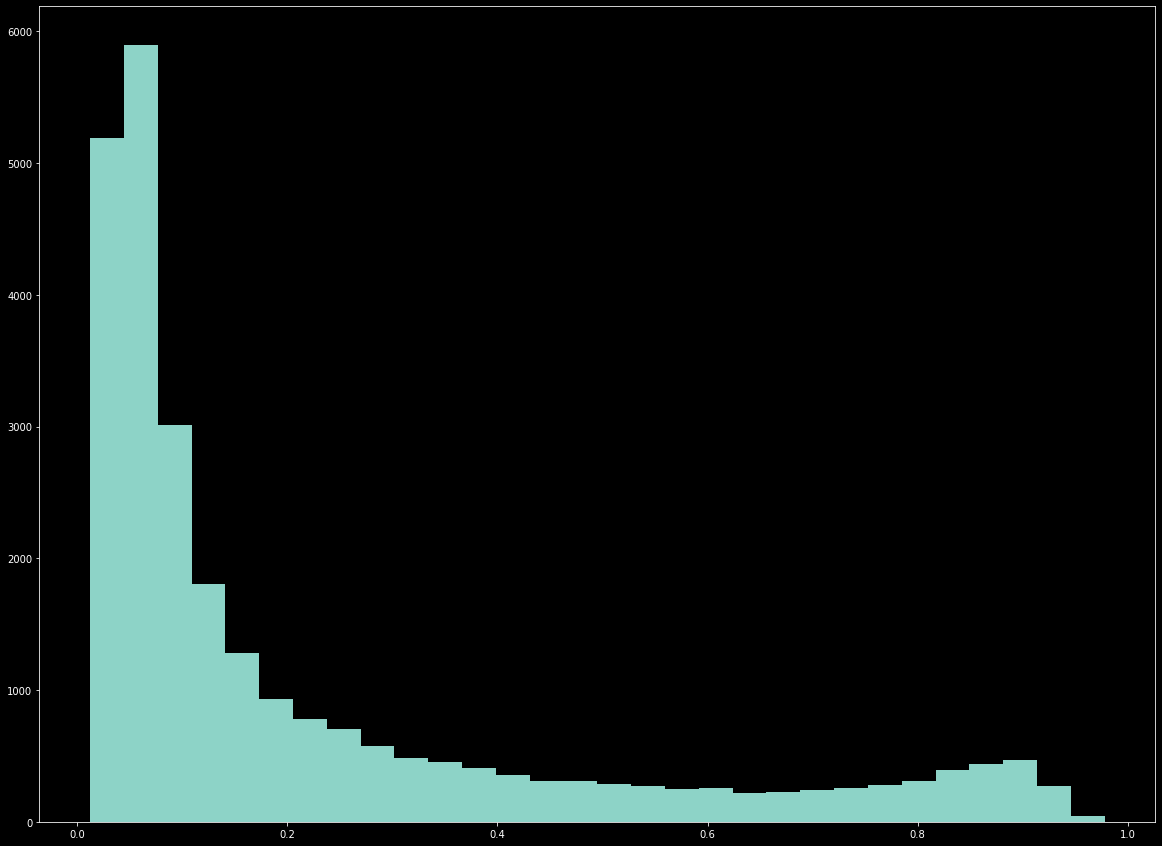

In [16]:
plt.hist(submission_df.h1n1_vaccine, bins=30);

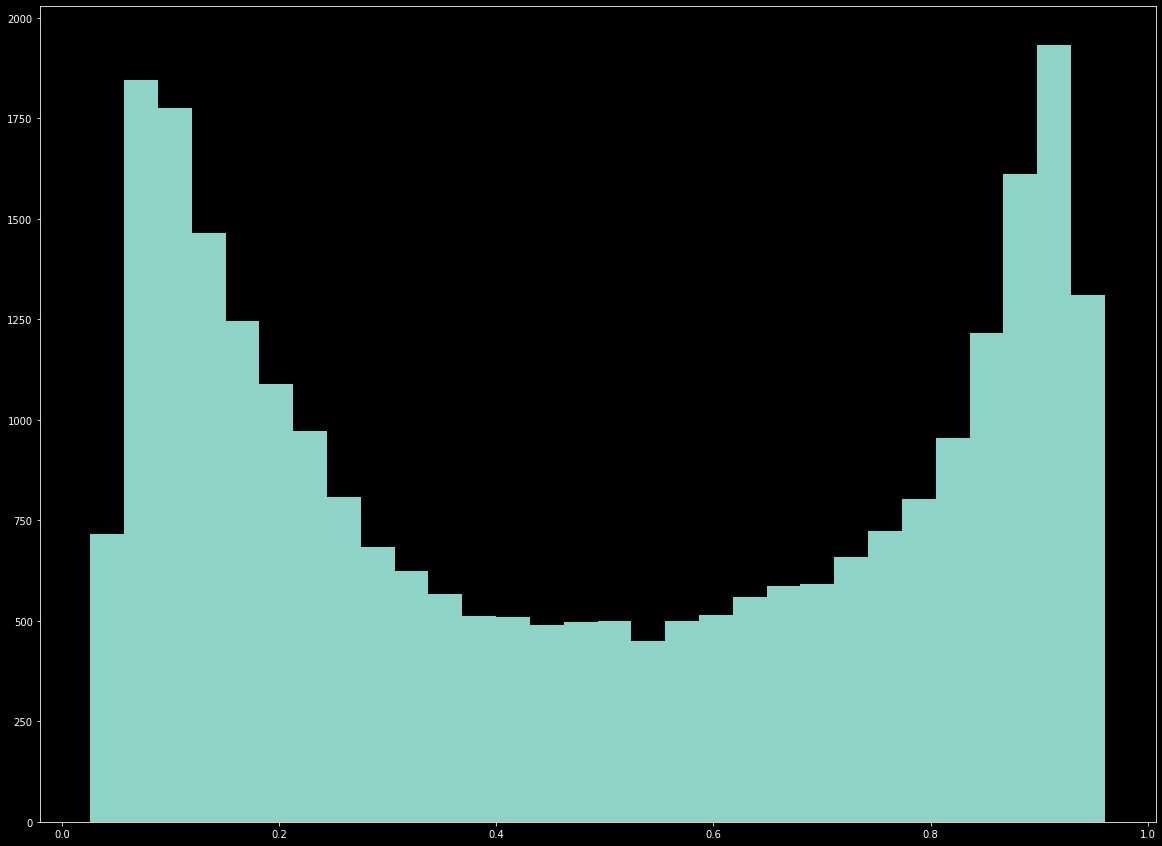

In [17]:
plt.hist(submission_df.seasonal_vaccine, bins=30);


In [18]:
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.131509,0.198598
26708,0.035862,0.050579
26709,0.159044,0.733579
26710,0.613957,0.872352
26711,0.384171,0.653710


In [19]:
submission_df.to_csv("./flu_submission1.csv")

In [20]:
print(Path.cwd())



/home/sergey/mnt/st1500/Usr/Sergey/TheJob/Otus/ML_advanced2020/home_works/1. Auto_ML/drivendata_flu_shot
